In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from default_func import extract_image_file_name_from_lidar_file_name, extract_bboxes_file_name_from_image_file_name

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from os.path import join
import glob

root_path_train = '.\\camera_lidar_semantic_bboxes\\train\\'
# get the list of files in lidar directory
file_names_lidar_train = sorted(glob.glob(join(root_path_train, '*\\lidar\\cam_front_center\\*.npz')))

root_path_test = '.\\camera_lidar_semantic_bboxes\\test\\'
# get the list of files in lidar directory
file_names_lidar_test = sorted(glob.glob(join(root_path_test, '*\\lidar\\cam_front_center\\*.npz')))

file_names_photo_train = []

for file_name_lidar in file_names_lidar_train:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_train, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_train.append(file_name_image)

file_names_photo_test = []

for file_name_lidar in file_names_lidar_test:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_test, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_test.append(file_name_image)

file_names_bboxes_train = []

for file_name_image, file_name_lidar in zip(file_names_photo_train, file_names_lidar_train):
    seq_name = file_name_lidar.split('\\')[3]
    file_name_bboxes = extract_bboxes_file_name_from_image_file_name(file_name_image)
    file_name_bboxes = join(root_path_train, seq_name, 'label3D\\cam_front_center\\', file_name_bboxes)
    file_names_bboxes_train.append(file_name_bboxes)

file_names_bboxes_test = []

for file_name_image, file_name_lidar in zip(file_names_photo_test, file_names_lidar_test):
    seq_name = file_name_lidar.split('\\')[3]
    file_name_bboxes = extract_bboxes_file_name_from_image_file_name(file_name_image)
    file_name_bboxes = join(root_path_test, seq_name, 'label3D\\cam_front_center\\', file_name_bboxes)
    file_names_bboxes_test.append(file_name_bboxes)

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from default_func import read_bounding_boxes_2d

def resize_bboxes(bboxes, original_size, target_size):
    """
    Масштабирует bounding box'ы при изменении размера изображения.
    
    Args:
        bboxes (torch.Tensor): Тензор размером [N, 4] с координатами [left, top, right, bottom]
        original_size (tuple): Исходный размер изображения (width, height)
        target_size (tuple): Целевой размер изображения (width, height)
    
    Returns:
        torch.Tensor: Масштабированные bounding box'ы размером [N, 4]
    """
    orig_w, orig_h = original_size  # <- ИЗМЕНИЛОСЬ: (width, height)
    target_w, target_h = target_size  # <- ИЗМЕНИЛОСЬ: (width, height)
    
    # Вычисляем коэффициенты масштабирования
    scale_x = target_w / orig_w
    scale_y = target_h / orig_h
    
    # Создаем копию тензора для избежания изменения оригинальных данных
    scaled_bboxes = bboxes.clone().float()
    
    # Масштабируем координаты
    scaled_bboxes[:, 0] *= scale_x  # left
    scaled_bboxes[:, 1] *= scale_y  # top
    scaled_bboxes[:, 2] *= scale_x  # right
    scaled_bboxes[:, 3] *= scale_y  # bottom
    
    return scaled_bboxes

class DetectionDataset(Dataset):
    def __init__(self, image_files, bbox_files, image_size=(300, 300), output_format="SSD"):
        self.image_files = image_files
        self.bbox_files = bbox_files
        self.image_size = image_size  # (height, width)
        self.output_format = output_format

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Загружаем картинку
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB")
        original_size = img.size  # (width, height)
        
        # Загружаем боксы
        target = read_bounding_boxes_2d(self.bbox_files[idx], original_size, output_format=self.output_format)
        
        # Сохраняем оригинальный размер для дебаггинга
        target['original_size'] = torch.tensor(original_size)
        
        # Преобразуем картинку
        img_transformed = self.transform(img)
        transformed_size = (img_transformed.shape[2], img_transformed.shape[1])  # (width, height)
        
        # Масштабируем боксы
        target['boxes'] = resize_bboxes(target['boxes'], original_size, transformed_size).to(device)
        #target['boxes'] = target['boxes'].to(device)
        target['labels'] = target['labels'].to(device)
        
        return img_transformed, target


# collate_fn для DataLoader
def collate_fn(batch):
    images = [item[0] for item in batch]   # список тензоров картинок
    images = torch.stack(images, dim=0).to(device)
    targets = [item[1] for item in batch]  # список словарей с боксами
    return images, targets


# Пример использования
train_dataset = DetectionDataset(file_names_photo_train, file_names_bboxes_train, image_size=(300, 300))
test_dataset  = DetectionDataset(file_names_photo_test, file_names_bboxes_test, image_size=(300, 300))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [8]:
import torchvision.ops as ops
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F

def apply_nms(predictions, iou_threshold=0.5, score_threshold=0.5):
    """
    Применяет Non-Maximum Suppression (NMS) к предсказаниям SSD.

    predictions: словарь с ключами 'boxes', 'labels', 'scores'
    iou_threshold: порог IoU для удаления дубликатов
    score_threshold: минимальная уверенность, с которой бокс считается валидным
    """
    result = []
    for predict in predictions:
        boxes = predict['boxes']
        scores = predict['scores']
        labels = predict['labels']

        # Оставляем только боксы с высокой уверенностью
        keep = scores > score_threshold
        boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

        # Применяем NMS
        keep_indices = ops.nms(boxes, scores, iou_threshold)

        result.append({
            'boxes': boxes[keep_indices],
            'labels': labels[keep_indices],
            'scores': scores[keep_indices]
        })

    return result

def visualize_batch_ssd(images, targets, class_names=None):
    batch_size = images.shape[0]  # Количество изображений в батче
    
    
    # ImageNet стандартные параметры нормализации
    IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
    IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])
    
    batch_size = images.shape[0]
    
    for i in range(batch_size):
        # Денормализуем ImageNet
        img = images[i].cpu().clone()
        
        # Денормализация: image = (image * std) + mean
        for c in range(3):
            img[c] = img[c] * IMAGENET_STD[c] + IMAGENET_MEAN[c]
        
        # Обрезаем значения в диапазон [0, 1]
        img = torch.clamp(img, 0, 1)
        
        # Преобразуем в [0, 255] для визуализации
        img = (img * 255).byte()
        
        target = targets[i]
        boxes = target['boxes'].cpu().int()  # Достаем координаты боксов
        labels = target['labels'].cpu().tolist()  # Достаем метки классов
        scores = target['scores'].cpu().tolist()  # Достаем вероятности
        
        # Генерируем текстовые метки с учетом имен классов
        if class_names:
            labels = [f"{class_names[label]}: {score:.2f}" for label, score in zip(labels, scores)]
        else:
            labels = [f"{label}: {score:.2f}" for label, score in zip(labels, scores)]
        
        img = draw_bounding_boxes(img, boxes, labels=labels, colors="red", width=2)
        
        plt.figure(figsize=(6, 6))
        img = F.to_pil_image(img)
        plt.imshow(img)
        plt.axis("off")
        plt.show()

def visualize_batch_ssd_with_GT(images, targets, ground_truth, class_names=None, img_name = 'test_image', save = False):
    batch_size = images.shape[0]  # Количество изображений в батче
    
    
    # ImageNet стандартные параметры нормализации
    IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
    IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])
    
    batch_size = images.shape[0]
    
    for i in range(batch_size):
        # Денормализуем ImageNet
        img = images[i].cpu().clone()
        
        # Денормализация: image = (image * std) + mean
        for c in range(3):
            img[c] = img[c] * IMAGENET_STD[c] + IMAGENET_MEAN[c]
        
        # Обрезаем значения в диапазон [0, 1]
        img = torch.clamp(img, 0, 1)
        
        # Преобразуем в [0, 255] для визуализации
        img = (img * 255).byte()
        
        target = targets[i]
        boxes = target['boxes'].cpu().int()  # Достаем координаты боксов
        labels = target['labels'].cpu().tolist()  # Достаем метки классов
        scores = target['scores'].cpu().tolist()  # Достаем вероятности

        gt = ground_truth[i]
        boxes_gt = gt['boxes'].cpu().int()  # Достаем координаты боксов
        labels_gt = gt['labels'].cpu().tolist()  # Достаем метки классов
        scores_gt = gt['scores'].cpu().tolist()  # Достаем вероятности
        
        # Генерируем текстовые метки с учетом имен классов
        if class_names:
            labels = [f"{class_names[label]}: {score:.2f}" for label, score in zip(labels, scores)]
        else:
            labels = [f"{label}: {score:.2f}" for label, score in zip(labels, scores)]

        if class_names:
            labels_gt = [f"{class_names[label]}: {score:.2f}" for label, score in zip(labels_gt, scores_gt)]
        else:
            labels_gt = [f"{label}: {score:.2f}" for label, score in zip(labels_gt, scores_gt)]

        img = draw_bounding_boxes(img, boxes_gt, labels=labels_gt, colors="green", width=2)
        img = draw_bounding_boxes(img, boxes, labels=labels, colors="red", width=2)
        
        plt.figure(figsize=(6, 6))
        img = F.to_pil_image(img)
        plt.imshow(img)
        plt.axis("off")
        if save: 
            plt.savefig(f'{img_name}_{i}.png')
        else:
            plt.show()

tensor([[ 50.9310, 172.9621, 104.4278, 233.3817]], device='cuda:0')
tensor([[ 78.4002, 172.5718, 114.5123, 212.6317]], device='cuda:0')
tensor([[ 96.5992, 142.7170, 135.6053, 198.7801]], device='cuda:0')
tensor([[ 29.0596, 111.7089, 104.5112, 213.9216]], device='cuda:0')


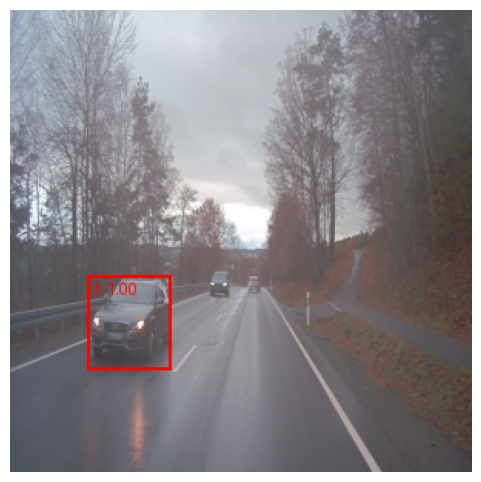

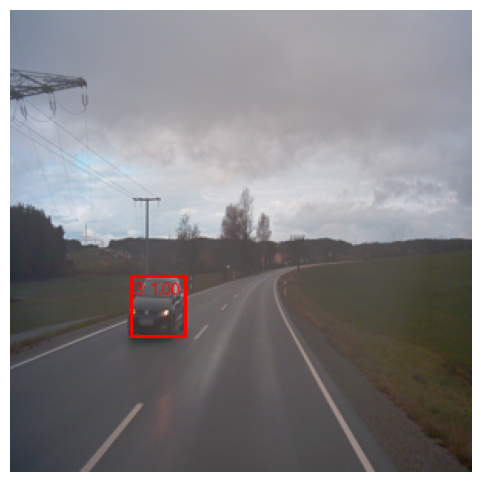

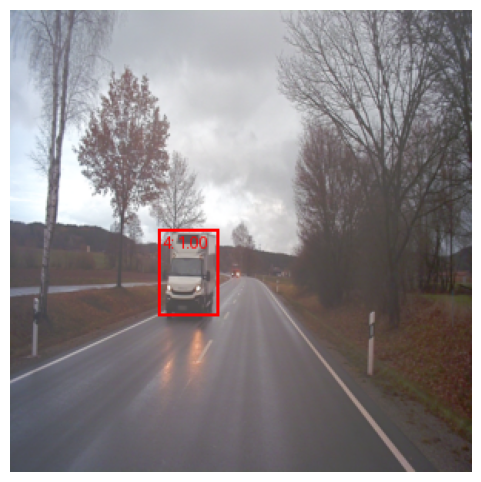

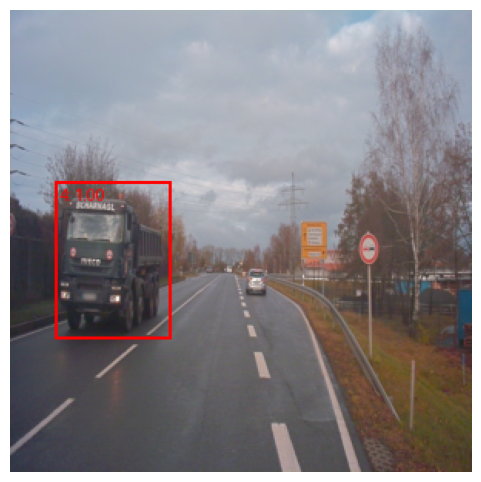

In [8]:
for images_test, targets_test in test_loader:
    #image = test_images[0].to(device)
    for target in targets_test:
        print(target['boxes'])
        n = len(target['labels'])
        target['scores'] = torch.ones(n, dtype=torch.float32)

    visualize_batch_ssd(images_test, targets_test)

    break

# Настройка якорных боксов в SSD

1. ***aspect_ratios***: Соотношения сторон якорных рамок.

- [2] = 1:2 и 2:1 (добавляется обратное значение)
- [2, 3] = 1:2, 1:3, 2:1, 3:1
2. ***num_anchors_per_location()***: Рассчитывает количество якорей для каждой клетки feature map.

- Для [2] = 4 якоря (2 aspect ratios × 2 scales)
- Для [2, 3] = 6 якорей (4 aspect ratios × 2 scales)
3. Размеры feature maps в ***out_channels*** указываются в обратном порядке !!! 
- Сначала layer4, потом layer3 и тд

In [9]:
import torchvision
import torch.nn as nn
from torchvision.models.detection.ssd import (
    SSD, 
    DefaultBoxGenerator,
    SSDHead
)
def create_model(num_classes=91, size=300, nms=0.45):
    model_backbone = torchvision.models.resnet34(
        weights=torchvision.models.ResNet34_Weights.DEFAULT
    )
    conv1 = model_backbone.conv1
    bn1 = model_backbone.bn1
    relu = model_backbone.relu
    max_pool = model_backbone.maxpool
    layer1 = model_backbone.layer1
    layer2 = model_backbone.layer2
    layer3 = model_backbone.layer3
    layer4 = model_backbone.layer4
    backbone = nn.Sequential(
        conv1, bn1, relu, max_pool, 
        layer1, layer2, layer3, layer4
    )
    out_channels = [512, 512, 512, 512, 512, 512]
    anchor_generator = DefaultBoxGenerator(
        [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
    )
    num_anchors = anchor_generator.num_anchors_per_location()
    head = SSDHead(out_channels, num_anchors, num_classes)
    model = SSD(
        backbone=backbone,
        num_classes=num_classes,
        anchor_generator=anchor_generator,
        size=(size, size),
        head=head,
        nms_thresh=nms
    )
    return model

In [16]:
import torchvision
import torch.nn as nn
from torchvision.models.detection.ssd import (
    SSD, 
    DefaultBoxGenerator,
    SSDHead
)

def create_model_resnet50(num_classes=91, size=300, nms=0.45):
    # Загружаем ResNet-50
    model_backbone = torchvision.models.resnet50(
        weights=torchvision.models.ResNet50_Weights.DEFAULT
    )
    
    # Создаем backbone (берем слои до avgpool)
    backbone = nn.Sequential(
        model_backbone.conv1,
        model_backbone.bn1,
        model_backbone.relu,
        model_backbone.maxpool,
        model_backbone.layer1,
        model_backbone.layer2,
        model_backbone.layer3,
        model_backbone.layer4
    )
    
    # Выходные каналы для каждой feature map
    # ResNet-50: [256, 512, 1024, 2048, 2048, 2048] 
    # out_channels = [64, 64, 256, 512, 1024, 2048]
    out_channels = [2048, 1024, 512, 256, 64, 64]
    
    # Anchor generator с подобранными параметрами
    anchor_generator = DefaultBoxGenerator(
        aspect_ratios=[
            [2],          # для самой мелкой feature map
            [2, 3],       # 
            [2, 3],       # для средних feature maps
            [2, 3],       #
            [2],          # 
            [2]           # для самой крупной feature map
        ],
    )
    
    num_anchors = anchor_generator.num_anchors_per_location()
    head = SSDHead(out_channels, num_anchors, num_classes)
    
    model = SSD(
        backbone=backbone,
        num_classes=num_classes,
        anchor_generator=anchor_generator,
        size=(size, size),
        head=head,
        nms_thresh=nms
    )
    return model

# Пример использования FeaturePyramidNetwork

Смысл - приравнять все feature map к одному размеру

In [27]:
import torchvision
import torch.nn as nn
from torchvision.models.detection.ssd import (
    SSD, 
    DefaultBoxGenerator,
    SSDHead
)
from torchvision.ops import FeaturePyramidNetwork

def create_model_resnet50_fpn(num_classes=91, size=300, nms=0.45):
    # Загружаем ResNet-50
    model_backbone = torchvision.models.resnet50(
        weights=torchvision.models.ResNet50_Weights.DEFAULT
    )
    
    # Создаем backbone и извлекаем feature maps с разных уровней
    class BackboneWithFPN(nn.Module):
        def __init__(self, resnet):
            super().__init__()
            self.conv1 = resnet.conv1
            self.bn1 = resnet.bn1
            self.relu = resnet.relu
            self.maxpool = resnet.maxpool
            self.layer1 = resnet.layer1  # 256 channels
            self.layer2 = resnet.layer2  # 512 channels
            self.layer3 = resnet.layer3  # 1024 channels
            self.layer4 = resnet.layer4  # 2048 channels
            
            # FPN для объединения feature maps
            self.fpn = FeaturePyramidNetwork(
                in_channels_list=[256, 512, 1024, 2048],
                out_channels=512
            )
            
        def forward(self, x):
            # Прямой проход через ResNet
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.maxpool(x)
            
            # Сохраняем feature maps с разных уровней в словарь
            features = {}
            x = self.layer1(x); features['0'] = x  # 256 channels
            x = self.layer2(x); features['1'] = x  # 512 channels  
            x = self.layer3(x); features['2'] = x  # 1024 channels
            x = self.layer4(x); features['3'] = x  # 2048 channels
            
            # Применяем FPN
            features = self.fpn(features)
            
            return features
    
    backbone = BackboneWithFPN(model_backbone)
    
    # Теперь все feature maps имеют 512 каналов!
    out_channels = [512, 512, 512, 512]
    
    # Anchor generator
    anchor_generator = DefaultBoxGenerator(
        aspect_ratios=[
            [2, 3],     # для самого глубокого уровня (мелкие объекты)
            [2, 3],     # 
            [2, 3],     # для средних уровней
            [2]         # для самого высокого уровня (крупные объекты)
        ],
    )
    
    num_anchors = anchor_generator.num_anchors_per_location()
    head = SSDHead(out_channels, num_anchors, num_classes)
    
    model = SSD(
        backbone=backbone,
        num_classes=num_classes,
        anchor_generator=anchor_generator,
        size=(size, size),
        head=head,
        nms_thresh=nms
    )
    return model

In [100]:
import torch.optim.lr_scheduler as lr_scheduler

#device = 'cpu'

# Определяем нужное число классов (например, 8 классов + фон)
num_classes = 6 + 1

# model = create_model(num_classes=num_classes, size=300, nms=0.45).to(device)
model = create_model_resnet50_fpn(num_classes=num_classes, size=300, nms=0.45).to(device)
# model = create_model_resnet50(num_classes=num_classes, size=300, nms=0.45).to(device)


# Оптимизатор
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

# Планировщик (каждые 10 эпох уменьшает lr в 2 раза)
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

In [29]:
num_epochs = 40
history = []
history_test = []

In [54]:
from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_test_loss = 0

    # Прогресс-бар для обучающего цикла
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1} Train", leave=False):
        try:
            optimizer.zero_grad()
            loss_dict = model(images, targets)  # Обучение модели (SSD/Faster R-CNN выдаёт лоссы)
            loss = sum(loss for loss in loss_dict.values())

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        except:
            print('Box zeros')

    avg_train_loss = total_loss / len(train_loader)
    history.append(avg_train_loss)
    #history.append(total_loss)

    # Прогресс-бар для тестового цикла
    for images_test, targets_test in tqdm(test_loader, desc=f"Epoch {epoch+1} Test", leave=False):
        try:
            loss_dict = model(images_test, targets_test)  # Тест модели
            loss = sum(loss for loss in loss_dict.values())
            total_test_loss += loss.item()
        except:
            print('Box zeros')

    avg_test_loss = total_test_loss / len(test_loader)
    history_test.append(avg_test_loss)
    #history_test.append(total_test_loss)

    # Обновляем learning rate на основе test loss
    #scheduler.step(avg_test_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

Epoch 1 Train:   8%|▊         | 243/3059 [01:36<17:40,  2.66it/s]

Box zeros


Epoch 1 Train:  22%|██▏       | 658/3059 [04:19<14:24,  2.78it/s]

Box zeros


Epoch 1, Train Loss: 1.7991, Test Loss: 2.7268


Epoch 2 Train:  14%|█▍        | 423/3059 [02:48<16:09,  2.72it/s]

Box zeros


Epoch 2 Train:  95%|█████████▌| 2919/3059 [19:36<00:54,  2.57it/s]

Box zeros


Epoch 2, Train Loss: 1.6694, Test Loss: 2.7103


Epoch 3 Train:   5%|▍         | 141/3059 [00:55<17:23,  2.80it/s]

Box zeros


Epoch 3 Train:  38%|███▊      | 1154/3059 [07:39<11:42,  2.71it/s]

Box zeros


Epoch 3, Train Loss: 1.5333, Test Loss: 2.8758


Epoch 4 Train:  12%|█▏        | 352/3059 [02:18<16:45,  2.69it/s]

Box zeros


Epoch 4 Train:  66%|██████▋   | 2027/3059 [13:33<06:42,  2.57it/s]

Box zeros


Epoch 4, Train Loss: 1.4500, Test Loss: 3.0229


Epoch 5 Train:   7%|▋         | 226/3059 [01:29<16:49,  2.81it/s]

Box zeros


Epoch 5 Train:  58%|█████▊    | 1784/3059 [11:56<07:55,  2.68it/s]

Box zeros


Epoch 5, Train Loss: 1.3737, Test Loss: 2.8696


Epoch 6 Train:  18%|█▊        | 555/3059 [03:38<16:01,  2.60it/s]

Box zeros


Epoch 6 Train:  78%|███████▊  | 2378/3059 [15:55<04:29,  2.53it/s]

Box zeros


Epoch 6, Train Loss: 1.2631, Test Loss: 2.9441


Epoch 7 Train:   8%|▊         | 242/3059 [01:35<17:02,  2.75it/s]

Box zeros


Epoch 7 Train:  63%|██████▎   | 1925/3059 [12:51<07:21,  2.57it/s]

Box zeros


Epoch 7, Train Loss: 1.2030, Test Loss: 2.9305


Epoch 8 Train:  22%|██▏       | 660/3059 [04:22<15:03,  2.66it/s]

Box zeros


Epoch 8 Train:  66%|██████▋   | 2030/3059 [13:37<06:28,  2.65it/s]

Box zeros


Epoch 8, Train Loss: 1.1453, Test Loss: 2.8698


Epoch 9 Train:   6%|▋         | 196/3059 [01:17<17:34,  2.72it/s]

Box zeros


Epoch 9 Train:  95%|█████████▍| 2899/3059 [19:30<01:03,  2.53it/s]

Box zeros


Epoch 9, Train Loss: 1.0845, Test Loss: 3.0422


Epoch 10 Train:  16%|█▋        | 498/3059 [03:16<16:07,  2.65it/s]

Box zeros


Epoch 10 Train:  78%|███████▊  | 2374/3059 [15:53<04:22,  2.61it/s]

Box zeros


Epoch 10, Train Loss: 1.0345, Test Loss: 3.1694


Epoch 11 Train:   6%|▌         | 176/3059 [01:09<17:28,  2.75it/s]

Box zeros


Epoch 11 Train:  79%|███████▊  | 2408/3059 [16:05<04:02,  2.68it/s]

Box zeros


Epoch 11, Train Loss: 1.0060, Test Loss: 3.1213


Epoch 12 Train:  45%|████▌     | 1379/3059 [09:09<10:53,  2.57it/s]

Box zeros


Epoch 12 Train:  58%|█████▊    | 1764/3059 [11:46<08:31,  2.53it/s]

Box zeros


Epoch 12, Train Loss: 0.9507, Test Loss: 3.1550


Epoch 13 Train:  71%|███████   | 2174/3059 [14:35<05:23,  2.73it/s]

Box zeros


Epoch 13 Train:  81%|████████  | 2466/3059 [16:33<03:46,  2.62it/s]

Box zeros


Epoch 13, Train Loss: 0.9169, Test Loss: 3.0604


Epoch 14 Train:   8%|▊         | 235/3059 [01:32<17:01,  2.76it/s]

Box zeros


Epoch 14 Train:  79%|███████▉  | 2415/3059 [16:10<04:12,  2.55it/s]

Box zeros


Epoch 14, Train Loss: 0.8809, Test Loss: 3.1926


Epoch 15 Train:  67%|██████▋   | 2039/3059 [13:36<06:22,  2.67it/s]

Box zeros


Epoch 15 Train:  98%|█████████▊| 3012/3059 [20:11<00:18,  2.60it/s]

Box zeros


Epoch 15, Train Loss: 0.8507, Test Loss: 3.1771


Epoch 16 Train:  30%|██▉       | 911/3059 [06:03<12:27,  2.87it/s]

Box zeros


Epoch 16 Train:  91%|█████████ | 2788/3059 [18:42<01:38,  2.75it/s]

Box zeros


Epoch 16, Train Loss: 0.8127, Test Loss: 3.3914


Epoch 17 Train:  56%|█████▌    | 1717/3059 [11:31<08:31,  2.62it/s]

Box zeros


Epoch 17 Train:  93%|█████████▎| 2859/3059 [19:12<01:16,  2.62it/s]

Box zeros


Epoch 17, Train Loss: 0.8085, Test Loss: 3.3703


Epoch 18 Train:  52%|█████▏    | 1584/3059 [10:35<09:37,  2.55it/s]

Box zeros


Epoch 18 Train:  67%|██████▋   | 2056/3059 [13:46<06:33,  2.55it/s]

Box zeros


Epoch 18, Train Loss: 0.7736, Test Loss: 3.2604


Epoch 19 Train:  61%|██████▏   | 1878/3059 [12:33<07:36,  2.59it/s]

Box zeros


Epoch 19 Train:  90%|████████▉ | 2742/3059 [18:20<01:56,  2.73it/s]

Box zeros


Epoch 19, Train Loss: 0.7401, Test Loss: 3.3169


Epoch 20 Train:  15%|█▍        | 449/3059 [02:58<16:01,  2.71it/s]

Box zeros


Epoch 20 Train:  55%|█████▌    | 1685/3059 [11:14<08:34,  2.67it/s]

Box zeros


Epoch 20, Train Loss: 0.7372, Test Loss: 3.4179


Epoch 21 Train:   9%|▊         | 267/3059 [01:45<17:14,  2.70it/s]

Box zeros


Epoch 21 Train:  80%|███████▉  | 2439/3059 [16:20<03:56,  2.62it/s]

Box zeros


Epoch 21, Train Loss: 0.7014, Test Loss: 3.8953


Epoch 22 Train:   7%|▋         | 201/3059 [01:19<17:21,  2.74it/s]

Box zeros


Epoch 22 Train:  24%|██▍       | 743/3059 [04:54<13:44,  2.81it/s]

Box zeros


Epoch 22, Train Loss: 0.7086, Test Loss: 3.4667


Epoch 23 Train:  20%|██        | 617/3059 [04:05<15:18,  2.66it/s]

Box zeros


Epoch 23 Train:  72%|███████▏  | 2205/3059 [14:46<05:21,  2.66it/s]

Box zeros


Epoch 23, Train Loss: 0.6656, Test Loss: 3.5149


Epoch 24 Train:   1%|          | 28/3059 [00:11<18:49,  2.68it/s]

Box zeros


Epoch 24 Train:  81%|████████▏ | 2493/3059 [16:45<03:30,  2.69it/s]

Box zeros


Epoch 24, Train Loss: 0.6726, Test Loss: 3.5172


Epoch 25 Train:  21%|██▏       | 656/3059 [04:21<15:00,  2.67it/s]

Box zeros


Epoch 25 Train:  33%|███▎      | 1001/3059 [06:39<13:30,  2.54it/s]

Box zeros


Epoch 25, Train Loss: 0.6262, Test Loss: 3.6017


Epoch 26 Train:  76%|███████▌  | 2330/3059 [15:33<04:30,  2.69it/s]

Box zeros


Epoch 26 Train:  81%|████████  | 2469/3059 [16:30<03:40,  2.68it/s]

Box zeros


Epoch 26, Train Loss: 0.6144, Test Loss: 3.5301


Epoch 27 Train:  45%|████▍     | 1367/3059 [09:08<10:22,  2.72it/s]

Box zeros


Epoch 27 Train:  85%|████████▌ | 2612/3059 [17:29<02:30,  2.97it/s]

Box zeros


Epoch 27, Train Loss: 0.6002, Test Loss: 3.5710


Epoch 28 Train:  47%|████▋     | 1430/3059 [09:30<10:38,  2.55it/s]

Box zeros


Epoch 28 Train:  67%|██████▋   | 2046/3059 [13:38<06:30,  2.60it/s]

Box zeros


Epoch 28, Train Loss: 0.6174, Test Loss: 3.7226


Epoch 29 Train:  18%|█▊        | 548/3059 [03:36<15:48,  2.65it/s]

Box zeros


Epoch 29 Train:  75%|███████▌  | 2295/3059 [15:21<04:43,  2.69it/s]

Box zeros


Epoch 29, Train Loss: 0.5733, Test Loss: 3.6650


Epoch 30 Train:  11%|█         | 332/3059 [02:11<16:56,  2.68it/s]

Box zeros


Epoch 30 Train:  69%|██████▊   | 2099/3059 [14:03<06:00,  2.66it/s]

Box zeros


Epoch 30 Train:  97%|█████████▋| 2959/3059 [19:54<00:40,  2.50it/s]

Box zeros


KeyboardInterrupt: 

In [58]:
checkpoint = {
    'epoch': epoch,  # количество выполненных эпох
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': total_loss,  # значение функции потерь
    # можно добавлять и другие метрики, нужные для ваших экспериментов
}
torch.save(checkpoint, '.\\models\\pitstop_ssd_rn50_fpn.pth')

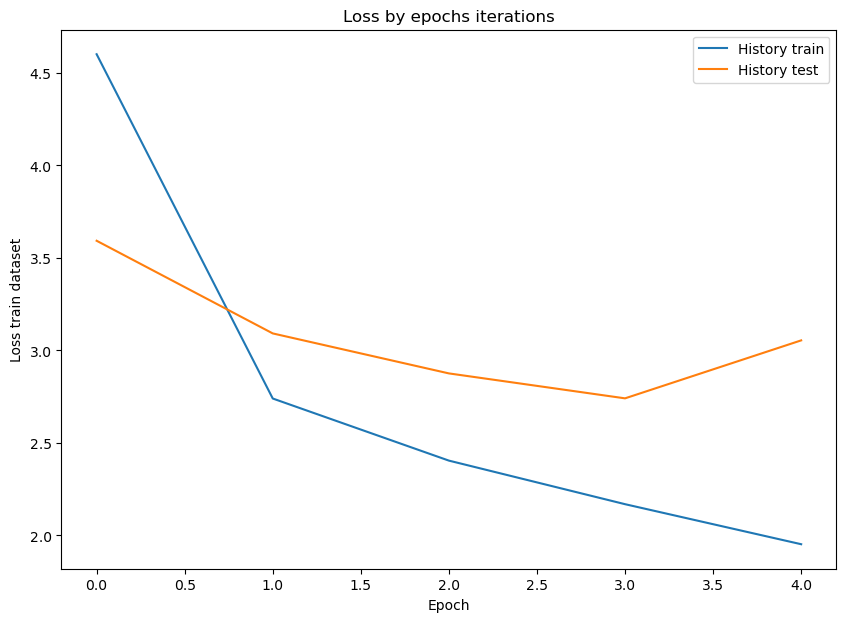

In [32]:
plt.figure(figsize=(10, 7))
plt.plot(history, label = 'History train')
plt.plot(history_test, label = 'History test')
plt.title('Loss by epochs iterations')
plt.ylabel('Loss train dataset')
plt.xlabel('Epoch')
#plt.yscale('log')
#plt.xscale('log')
plt.legend()

plt.show()

In [101]:
checkpoint = torch.load('.\\models\\pitstop_ssd_rn50_fpn.pth', map_location=device)
    
# Загружаем состояние модели
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

  0%|          | 0/66 [00:00<?, ?it/s]

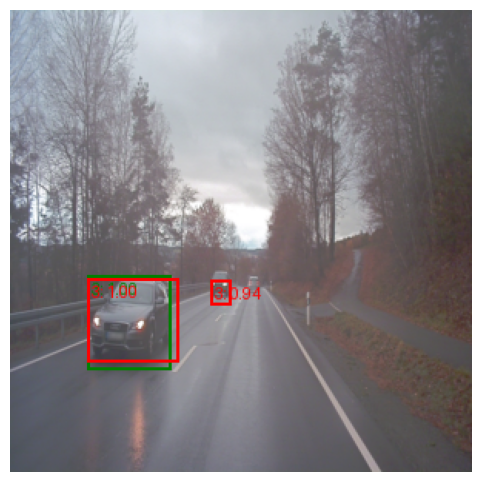

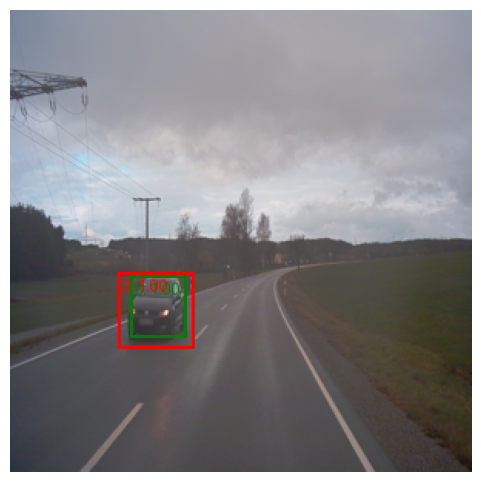

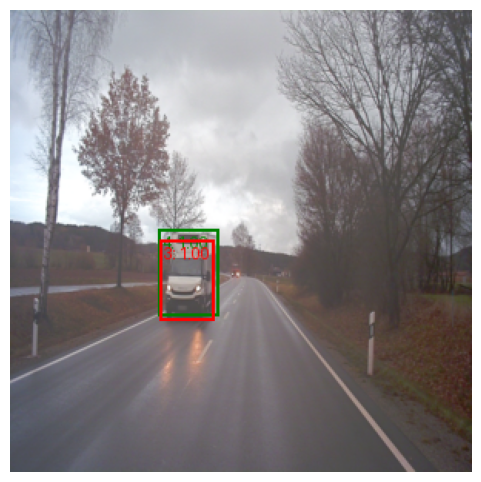

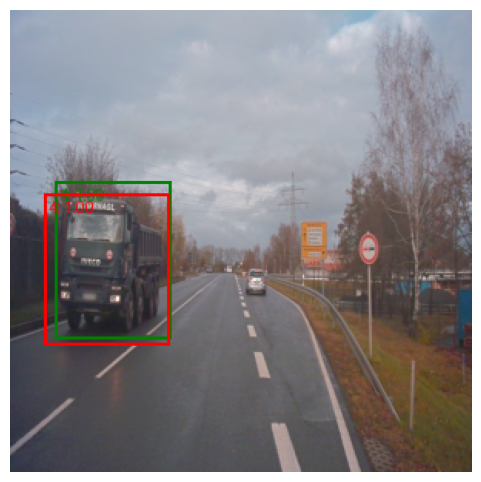

  0%|          | 0/66 [00:01<?, ?it/s]


In [102]:
# Визуализация на тест сете
model.eval()
num = 0

for images_test, targets_test in tqdm(test_loader):
    #image = test_images[0].to(device)
    predictions = model(images_test)
    for target in targets_test:
        n = len(target['labels'])
        target['scores'] = torch.ones(n, dtype=torch.float32)
    filtered_preds = apply_nms(predictions)
    visualize_batch_ssd_with_GT(images_test, filtered_preds, targets_test, img_name= f'.\\tests\\ssd_custom\\test_image_bach_{num}', save= False)
    num +=1

    break

In [103]:
from tqdm import tqdm

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for images_test, targets_test in tqdm(test_loader):
        preds = model(images_test)
        preds = apply_nms(preds)  # твоя фильтрация NMS

        # preds уже список словарей: [{'boxes':..., 'labels':..., 'scores':...}, ...]
        # targets_test — список словарей: [{'boxes':..., 'labels':...}, ...]

        all_preds.extend(preds)
        all_targets.extend(targets_test)


100%|██████████| 66/66 [00:24<00:00,  2.70it/s]


In [67]:
import torch
import numpy as np
from collections import defaultdict
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt


def box_iou(boxes1, boxes2):
    area1 = (boxes1[:, 2] - boxes1[:, 0]).clamp(min=0) * (boxes1[:, 3] - boxes1[:, 1]).clamp(min=0)
    area2 = (boxes2[:, 2] - boxes2[:, 0]).clamp(min=0) * (boxes2[:, 3] - boxes2[:, 1]).clamp(min=0)

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  

    wh = (rb - lt).clamp(min=0)  
    inter = wh[..., 0] * wh[..., 1]  

    union = area1[:, None] + area2 - inter
    return inter / union.clamp(min=1e-6)


def collect_class_detections(all_preds, all_targets, class_id, iou_threshold=0.5):
    y_true, y_scores = [], []

    for pred, target in zip(all_preds, all_targets):
        preds_cls = pred['labels'] == class_id
        boxes_pred = pred['boxes'][preds_cls]
        scores_pred = pred['scores'][preds_cls]

        gts_cls = target['labels'] == class_id
        boxes_gt = target['boxes'][gts_cls]

        matched_gt = set()
        for box, score in zip(boxes_pred, scores_pred):
            if len(boxes_gt) > 0:
                ious = box_iou(box.unsqueeze(0), boxes_gt).squeeze(0)
                best_iou, idx = ious.max(0)
                if best_iou >= iou_threshold and idx.item() not in matched_gt:
                    y_true.append(1)
                    matched_gt.add(idx.item())
                else:
                    y_true.append(0)
            else:
                y_true.append(0)

            y_scores.append(score.item())

        # FN для оставшихся GT
        for _ in range(len(boxes_gt) - len(matched_gt)):
            y_true.append(1)
            y_scores.append(0.0)

    return np.array(y_true), np.array(y_scores)


def evaluate_map(all_preds, all_targets, class_ids, iou_threshold=0.5, plot_classes=None):
    aps = {}
    pr_curves = {}  # тут будем хранить кривые: {class_id: (precision, recall)}

    for cid in class_ids:
        y_true, y_scores = collect_class_detections(all_preds, all_targets, cid, iou_threshold)

        if len(np.unique(y_true)) < 2:
            continue

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        ap = auc(recall, precision)
        aps[cid] = ap
        pr_curves[cid] = (precision, recall)

        if plot_classes and cid in plot_classes:
            plt.plot(recall, precision, label=f"Class {cid} (AP={ap:.3f})")

    if plot_classes:
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall curves")
        plt.legend()
        plt.grid()
        plt.show()

    mAP = np.mean(list(aps.values())) if aps else 0.0
    return mAP, aps, pr_curves


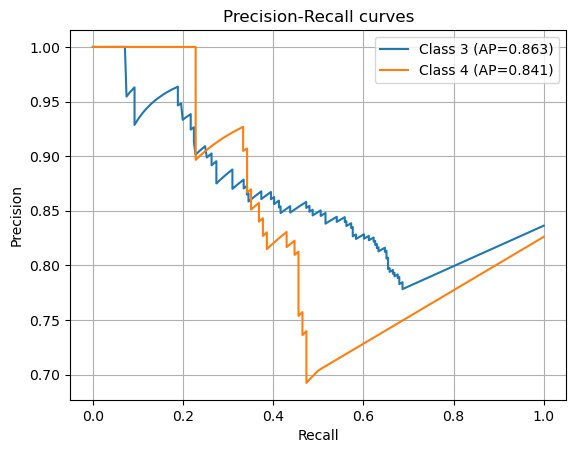

mAP: 0.8520167848630273
APs по классам: {3: 0.8631153808753812, 4: 0.8409181888506734}


In [104]:
# После инференса (как у тебя в коде):
# all_preds, all_targets собраны

class_ids = [3, 4]   # интересующие классы
mAP, aps, pr = evaluate_map(all_preds, all_targets, class_ids, iou_threshold=0.5, plot_classes=[3, 4])

print("mAP:", mAP)
print("APs по классам:", aps)


In [89]:
np.savez(".\\results_2d_detection\\pr_curves\\pr_curves_ssd_rn50.npz", **{str(k): v for k,v in pr.items()})